# Exercise 1 - Become a Data Engineer!

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
from tqdm import tqdm_notebook as tqdm
from matplotlib.ticker import MaxNLocator
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import zscore


## Dataset Description
The data set you will analyze in all exercises was provided by Walmart and consists of unit sales data of 3049 products sold in the U.S. over 1941 days (from 2011-01-29 to 2016-04-24), organized in the form of grouped time series. Similar to the Capstone project, the goal of this series of exercises is to accurately predict the daily unit sales of retail stores across locations and product categories for the next 28 days, as well as to accurately estimate the uncertainty distribution of the predicted value.

#### Sales
The dataset is a grouped time series because there is a hierarchy of different levels of aggregation, and depending on the level of aggregation used to examine the data, it is possible to obtain a different set of time series with different levels of granularity. The disaggregated data can be grouped based on either location (store and state) or product-related information (department and category):
- 3 product categories (*Hobby*, *Food* and *Household*),subdivided into 7 product departments, and a total of 3049 different products in these departments
- 3 states (California (*CA*), Texas (*TX*), and Wisconsin (*WI*)), in which 10 stores are located

Based on this groupings, several meaningful hierarchies and hence time series can be constructed from the data at different levels of aggregation. If each product is considered separately for each state, we have 30,490 different time series.

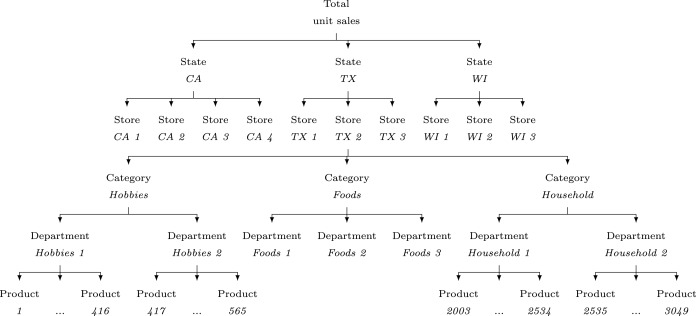

The 'sales_train' table contains the following columns:
- `id`: Unique id of a product in a certain store, combining all hierarchy information (store, state, department, and category) for the specific product. 
- `item_id`: Unique id of a specific product. 
- `dept_id`: Department of a specific product. 
- `cat_id`: Product category of a specific product. 
- `store_id`: Store in which the specific product was sold. 
- `state_id`: State in which the specific product was sold. 
- `d_1` bis `d_1941`: For each of the 1941 days, how many times the product has been sold on that day.

In [67]:
sales_train = pd.read_parquet('data/sales_train_evaluation.parquet')
sales_train_validation = pd.read_parquet('data/sales_train_validation.parquet')
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


#### Exogenous/explanatory data
In addition to the sales data, additional explanatory data are available that provide additional context and help to interpret the patterns found.   

**'prices'**
- `store_id`: ID of the store.
- `item_id`: Product ID.
- `wm_yr_wk`: Identifier of the date (d_1 bis d_1969).
- `sell_price`: Selling prices of the products, provided on a week–store level (average across seven days). If not available, this means that the product was not sold during the week examined.

In [68]:
sell_prices = pd.read_parquet('data/sell_prices.parquet')
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


**'calendar'**
- `date`: Date (YYYY-MM-DD)
- `wm_yr_wk`: Date identifier
- `weekday`: Weekday
- `wday`: Saturday = 1, Sunday = 2 … Friday = 7
- `month`: Month
- `year`: Year
- `d`: Date identifier (d_1 to d_1969)
- `event_name_1`: Special events, days and holidays (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter).
- `event_type_1`: Type of event (Cultural, Religious, Sporting, National).
- `event_name_2`: Name of the second event, if two events occur on the same day.
- `event_type_2`: Type of the second event, if two events occur on the same day.
- `snap_CA`: SNAP activities that serve as promotions. This is a binary variable (0 or 1) indicating whether the stores of *CA* allow SNAP purchases on the date examined, 1 indicates that SNAP purchases are allowed.
- `snap_TX`: SNAP activities for *TX* (Texas).
- `snap_WI`: SNAP activities for *WI* (Wisconsin).

SNAP is a social assistance program in the USA that provides money for food purchases for people in need using a debit card. The field is 1 if SNAP card purchases are allowed in CA (California) that day.


In [69]:
calendar = pd.read_parquet('data/calendar.parquet')
calendar.head(11)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,None,None,None,None,1,1,0


## Exercise 1

### 1) Quality check

Let's have a closer look at the sales_train dataframe.

In [70]:
print('sales_train shape:', sales_train.shape)

sales_train shape: (30490, 1947)


In [71]:
sales_train.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.445490,1.781174,1.965267,1.389374,1.271794,1.216661,1.212299,1.395605,1.689669,1.782158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.656824,4.426550,4.706284,3.313292,3.126178,3.000348,2.955910,3.514318,4.089208,4.284356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,143.000000,156.000000,187.000000,98.000000,90.000000,77.000000,84.000000,110.000000,156.000000,117.000000


#### 1.1 Check for duplicates

In [72]:
sales_train.duplicated(subset=['id']).sum()

0

Apparently, we do not have any duplicated `id`. This means, that for each of the 3049 products, we have exactly one line showing the sales on the 1941 days (in the columns) for each of the 10 stores. 

#### 1.2 Check if the difference between consecutive observations
We want to have check the time window between consecutive observations since some time series forecasting models require constant time windows between observations.

In [73]:
# extract all column names that start with 'd_'
d_columns = [int(col.split('_')[1]) for col in sales_train.columns if col.startswith('d_')]

#check space between consecutive observations
diff = np.diff(np.array(d_columns) )
#count how often each difference occurs
unique, counts = np.unique(diff, return_counts=True)
print('Space between consecutive observations and frequency of this spacing:', dict(zip(unique, counts)))

Space between consecutive observations and frequency of this spacing: {1: 1940}


We have one column for each of the days from 2011-01-29 to 2016-04-24

#### 1.3. Check for missing values
Next, we must check for missing data. To handle missing data, several strategies exist:
- **Imputation**: Missing values can be imputed using techniques like forward filling, backward filling, interpolation, or mean/median imputation.
- **Deletion**: In some cases, if the missing data is minimal, rows or columns with missing values can be dropped, though this might impact the dataset's integrity.
- **Predictive Models**: For more sophisticated imputation, machine learning algorithms can be used to predict missing values based on existing data.

In [74]:
#check for missing values
sales_train.isna().sum()    

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [75]:
missing_percentage = (sales_train.isnull().sum() / len(sales_train)) * 100
print(missing_percentage.mean(), '% of the values are missing in the sales_train dataset')
print('The following columns have missing values:', sales_train.columns[sales_train.isna().any()].tolist())

0.0 % of the values are missing in the sales_train dataset
The following columns have missing values: []


Apparently, we do not have any missing values, which is really nice but not usually the case in practice.

#### 1.4. Check for outliers

Let's have a look at the data to get a feeling, if there are any outliers in the time series.

<Axes: title={'center': 'Top-Level: Summed product sales of all stores and states'}, ylabel='Total unit sales'>

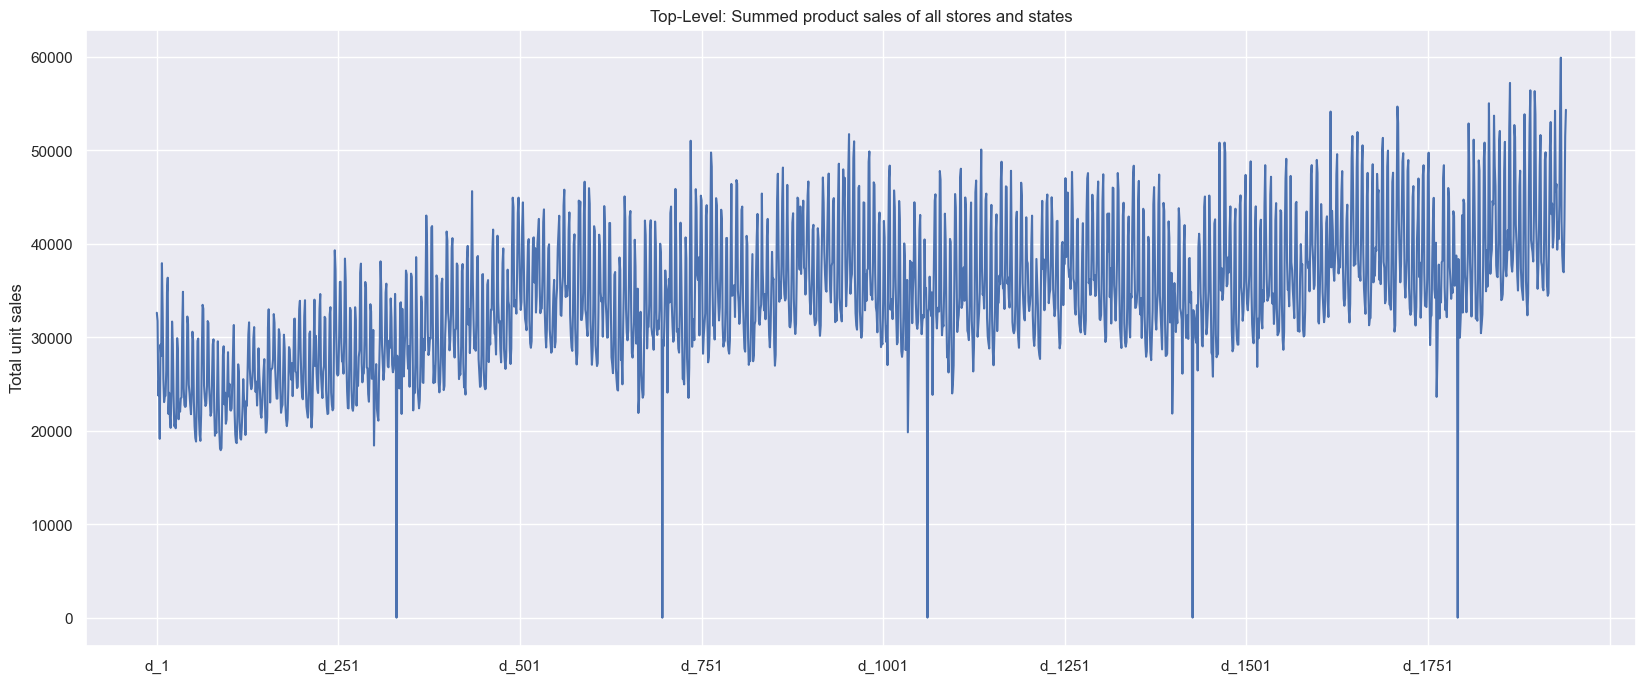

In [76]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title("Top-Level: Summed product sales of all stores and states")
ax.set_ylabel("Total unit sales")
sales_train.drop(['id','cat_id','item_id','dept_id','store_id', 'state_id'], axis =1).sum().plot(ax=ax)

It looks like there are some outliers in our time series. Let's try to identify those points using the Z-Score and see what days those are.

In [105]:
total_sales = sales_train.drop(['id','cat_id','item_id','dept_id','store_id', 'state_id'], axis=1).sum()

# Calculate the Z-scores for the total_sales
z_scores = zscore(total_sales)
total_sales = pd.DataFrame({'total_sales': total_sales, 'z_score': z_scores})

# Set a threshold to detect outliers 
threshold = 3.5
outliers = total_sales[np.abs(total_sales['z_score']) > threshold].copy()
outliers.loc[:, 'date'] = outliers.index
outliers.loc[:, 'date'] = outliers['date'].apply(lambda x: calendar.loc[calendar['d'] == x]['date'].values[0])

# Print out the detected outliers
print("Detected Outliers:")
print(outliers)


Detected Outliers:
        total_sales   z_score        date
d_331            13 -4.642753  2011-12-25
d_697            11 -4.643022  2012-12-25
d_1062           20 -4.641810  2013-12-25
d_1427           20 -4.641810  2014-12-25
d_1792           14 -4.642618  2015-12-25


Each year on christmas, sales drop to almost zero. Hence this date should be excluded when rolling windows are created to smoothen the data.

### 2) Visualize the data to check out the different aggregation levels

First, let's have a look at the different hierarchies of time series in our data set!

<Axes: title={'center': 'Level-1: Summed product sales per state'}, ylabel='Unit sales'>

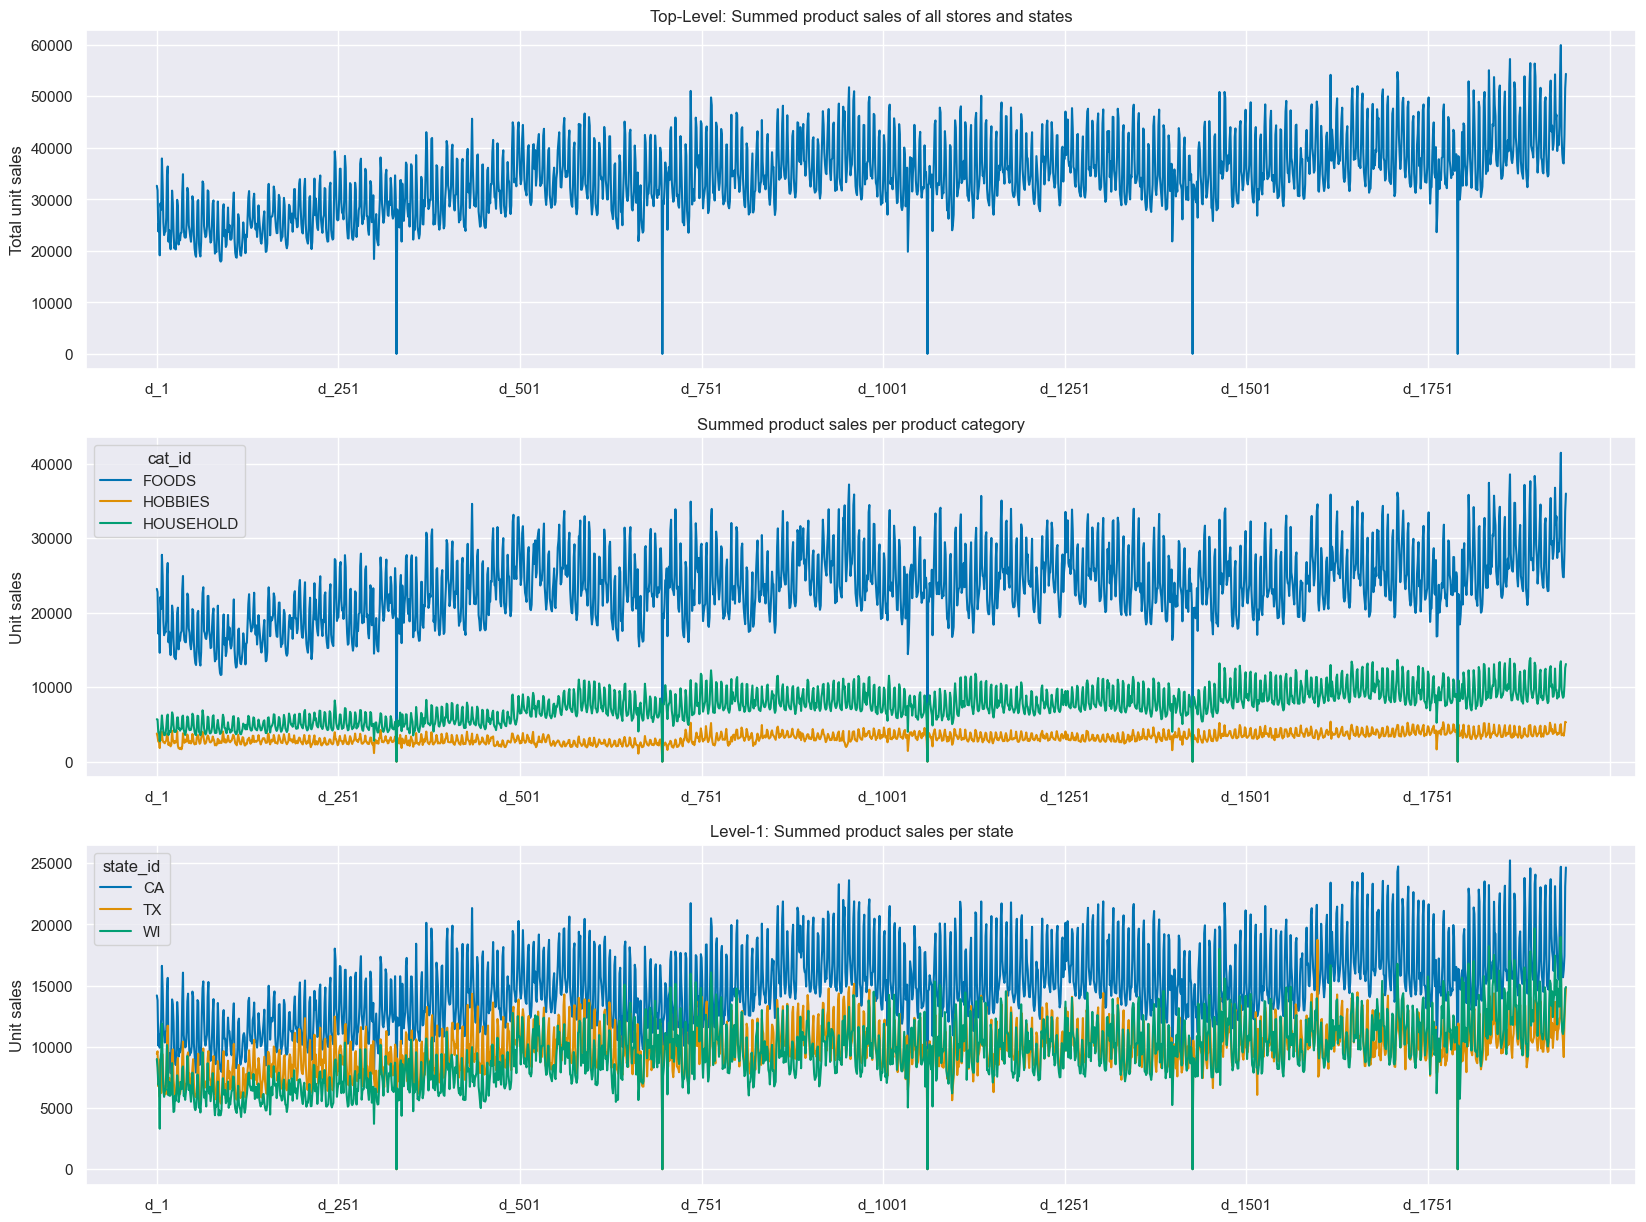

In [117]:
sns.set_palette("colorblind")
fig, ax = plt.subplots(3,1,figsize=(20,15))
ax[0].set_title("Top-Level: Summed product sales of all stores and states")
ax[0].set_ylabel("Total unit sales")
sales_train.drop(['id','cat_id','item_id','dept_id','store_id', 'state_id'], axis =1).sum().plot(ax=ax[0])
ax[1].set_title("Summed product sales per product category")
ax[1].set_ylabel("Unit sales")
sales_train.drop(['id','item_id','dept_id','store_id', 'state_id'], axis =1).groupby('cat_id').sum().transpose().plot(ax=ax[1])
ax[2].set_title("Level-1: Summed product sales per state")
ax[2].set_ylabel("Unit sales")
sales_train.drop(['id','item_id','dept_id','store_id', 'cat_id'], axis =1).groupby('state_id').sum().transpose().plot(ax=ax[2])


<Axes: title={'center': 'Sales for WI'}, ylabel='Unit sales'>

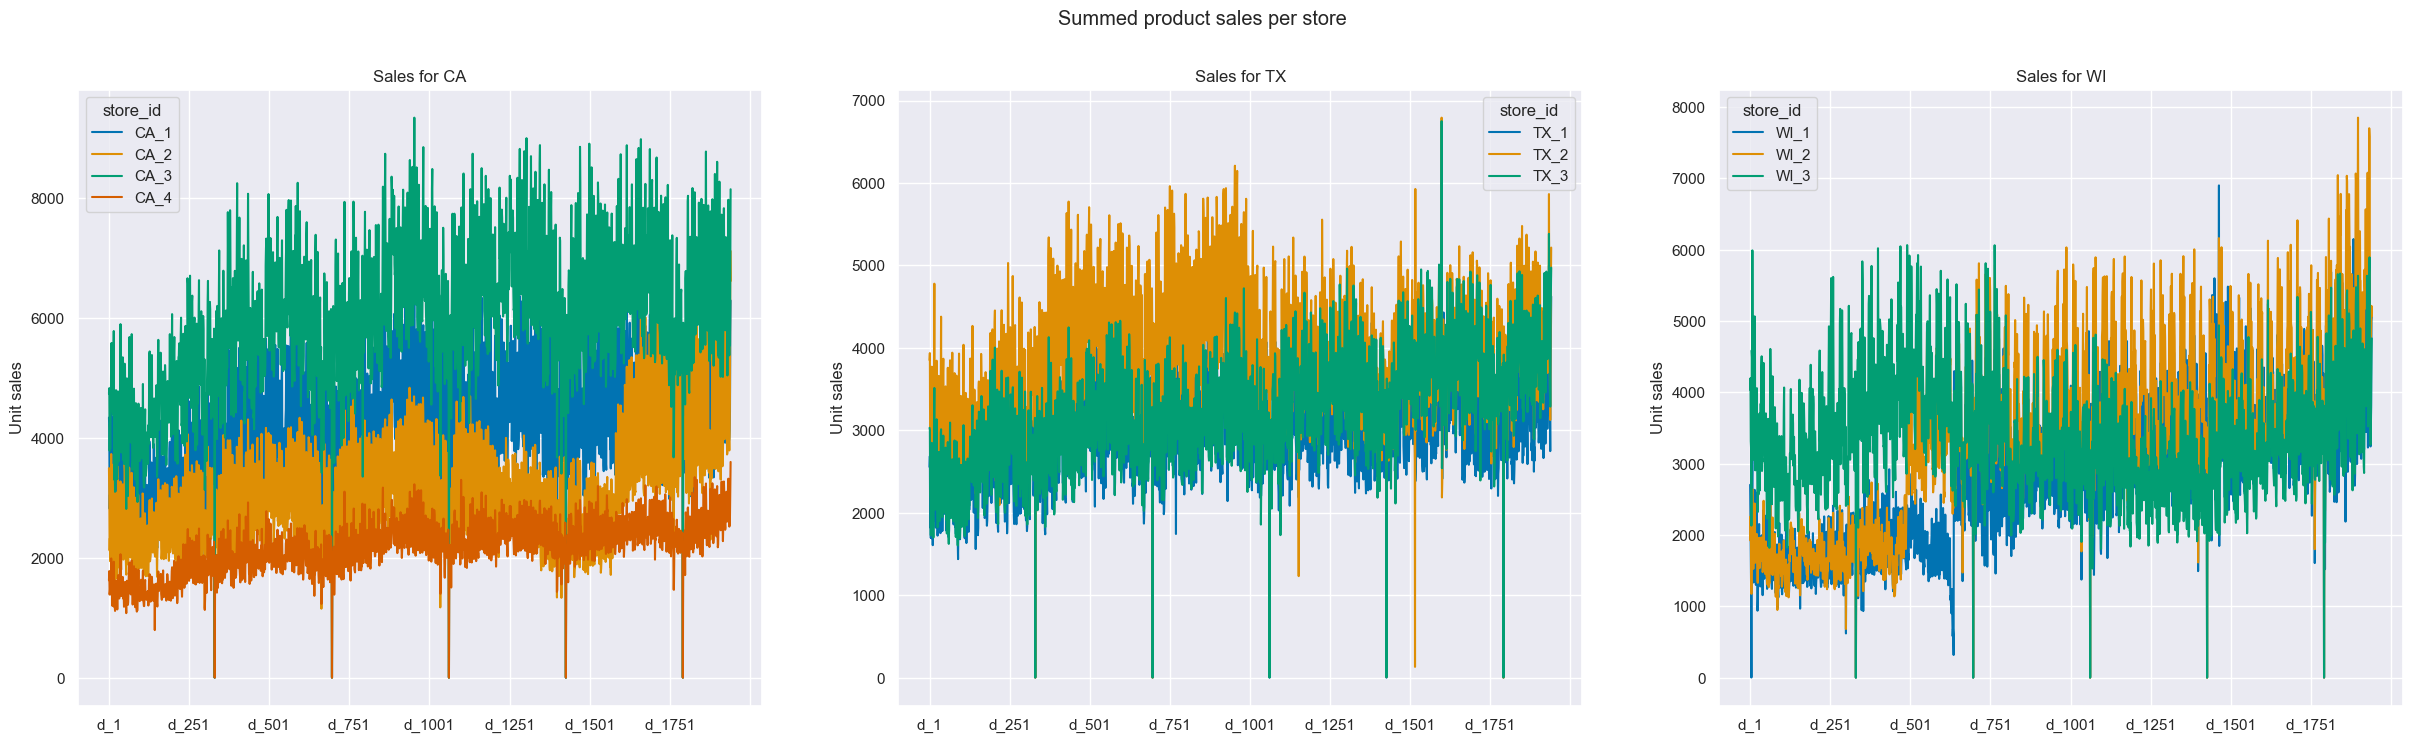

In [111]:
sns.set_palette("colorblind")
sales_per_store = sales_train.drop(['id','item_id','dept_id','state_id', 'cat_id'], axis =1).groupby('store_id').sum().transpose()
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle("Summed product sales per store")
ax[0].set_title("Sales for CA")
ax[0].set_ylabel("Unit sales")
sales_per_store.loc[:, sales_per_store.columns.str.contains("CA")].plot(ax=ax[0])
ax[1].set_title("Sales for TX")
ax[1].set_ylabel("Unit sales")
sales_per_store.loc[:, sales_per_store.columns.str.contains("TX")].plot(ax=ax[1])
ax[2].set_title("Sales for WI")
ax[2].set_ylabel("Unit sales")
sales_per_store.loc[:, sales_per_store.columns.str.contains("WI")].plot(ax=ax[2])

<Axes: title={'center': 'Sales for WI'}, ylabel='Unit sales'>

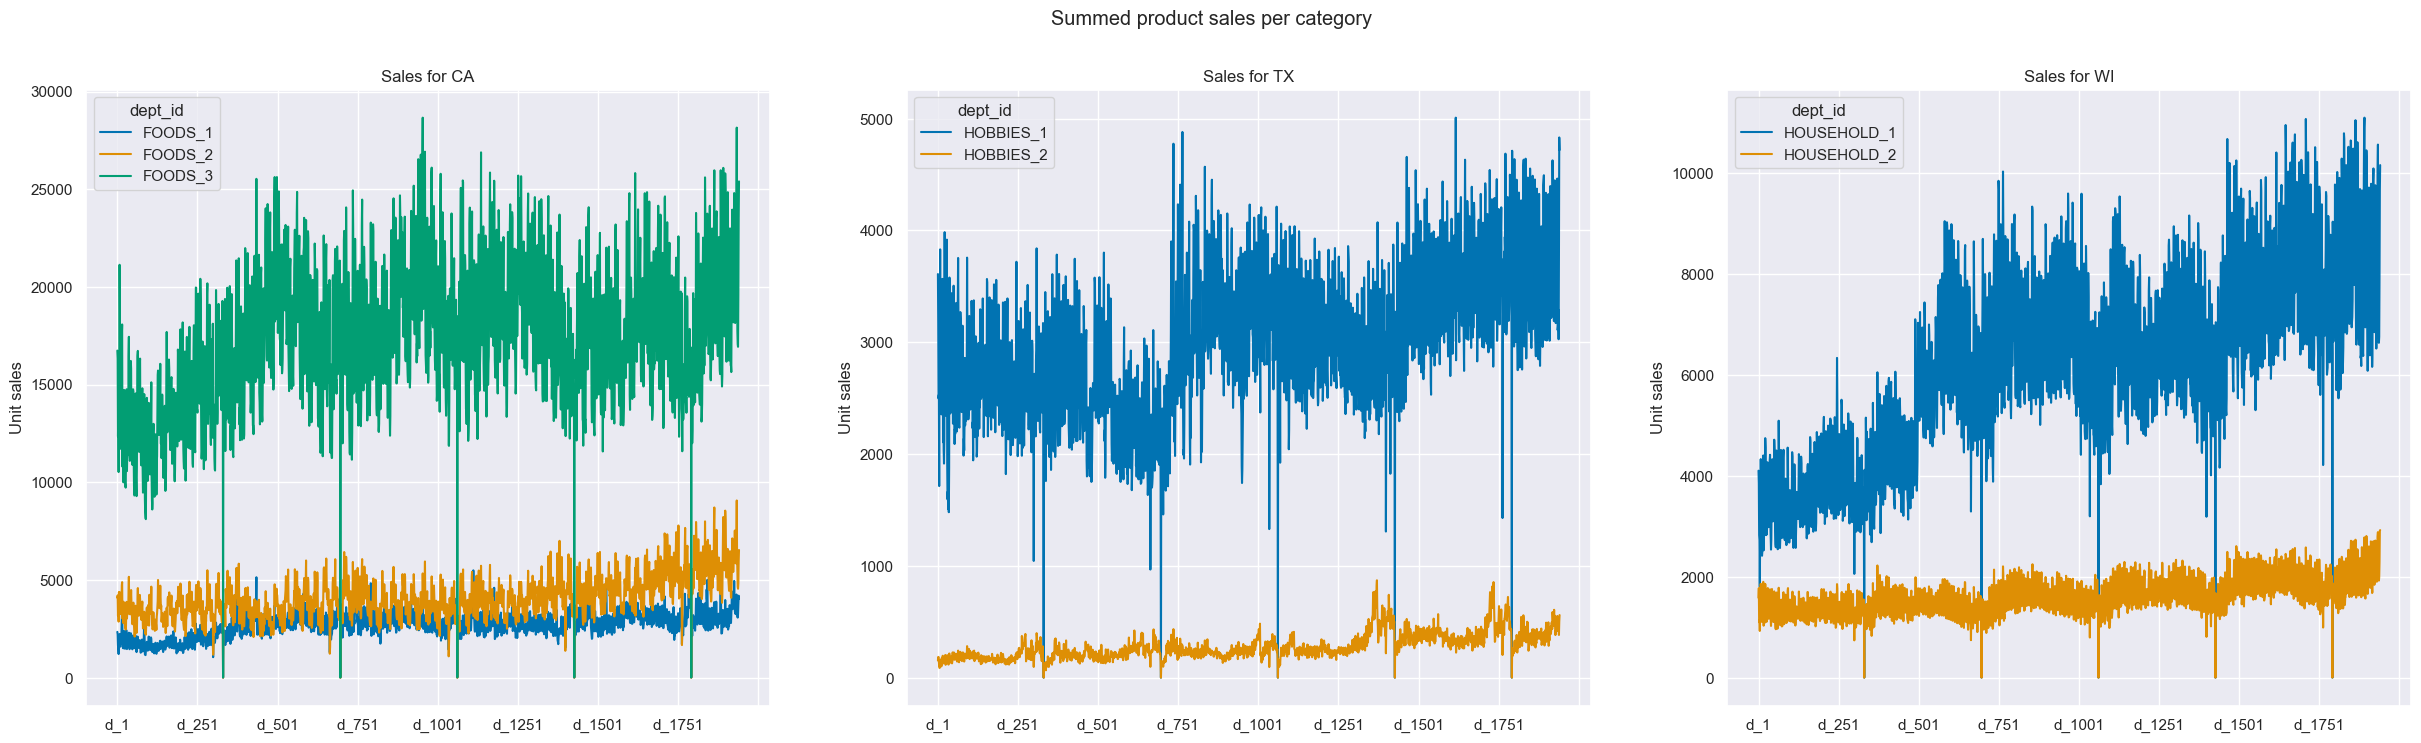

In [118]:
sns.set_palette("colorblind")
sales_per_cat=sales_train.drop(['id','item_id','store_id','state_id', 'cat_id'], axis =1).groupby('dept_id').sum().transpose()
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle("Summed product sales per category")
ax[0].set_title("Sales for CA")
ax[0].set_ylabel("Unit sales")
sales_per_cat.loc[:, sales_per_cat.columns.str.contains("FOODS")].plot(ax=ax[0])
ax[1].set_title("Sales for TX")
ax[1].set_ylabel("Unit sales")
sales_per_cat.loc[:, sales_per_cat.columns.str.contains("HOBBIES")].plot(ax=ax[1])
ax[2].set_title("Sales for WI")
ax[2].set_ylabel("Unit sales")
sales_per_cat.loc[:, sales_per_cat.columns.str.contains("HOUSE")].plot(ax=ax[2])

With this first overview of the development of sales data at the various aggregation levels, we can already observe some nice periodic patterns. 
- “Foods” are the most common category, followed by “Household” which is still quite a bit above “Hobbies”. Within the categories, the sales volumes for the different product departments are relatively well separated, only Foods_2 and Foods_3 perform similar. 
- The CA stores have a larger sales volume together than the stores in the other two states. However, if you look at the individual stores in CA, they are relatively spread out in terms of sales volume, while the TX and WI stores are quite close in terms of sales volume. WI stores “WI_1” and “WI_2” show a curious jump in sales in the beginning, while “WI_3” shows a long dip over several year.

### 3) Check for seasonal patterns

Moving on from the time series views, at least for the moment, we are changing up our visuals to study seasonalities. Because of the general increasing trend in sales (non-stationary data), we’re not looking at absolute sales values. Instead, we aim to model this trend using a smoothed (LOESS) fit which we then subtract from the data. Note, that christmas was removed since this is an outlier.

In [ ]:
#Define some order for the weekdays and months and the minimum date in the dataset
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
min_date = pd.Timestamp('2011-01-27')

In [ ]:
# Grouping the sales data by category and state
grouped_sales_train = sales_train.groupby(['cat_id', 'state_id']).apply(
    lambda x: x.filter(regex='^d_').sum(axis=0)
).reset_index()

# Creating the 'dates' column and adjusting the format
grouped_sales_train = grouped_sales_train.melt(id_vars=['cat_id', 'state_id'], value_vars=[col for col in grouped_sales_train.columns if col.startswith('d_')], var_name='dates', value_name='sales')
grouped_sales_train['dates'] = grouped_sales_train['dates'].str.replace('d_', '').astype(int)
grouped_sales_train['dates'] = min_date + pd.to_timedelta(grouped_sales_train['dates'] - 1, unit='D')

# Adding the weekday and month columns as categorical variables to enalble sorting
grouped_sales_train['wday'] = pd.Categorical(grouped_sales_train['dates'].dt.day_name(), categories=weekday_order, ordered=True)
grouped_sales_train['month'] = pd.Categorical(grouped_sales_train['dates'].dt.month_name(), categories=month_order, ordered=True)

# Filter out christmas since it is an outlier
grouped_sales_train = grouped_sales_train[~grouped_sales_train['dates'].dt.strftime('%m-%d').str.contains('12-25')]
grouped_sales_train

,cat_id,state_id,dates,sales,wday,month
0,FOODS,CA,2011-01-29,10101,Saturday,January
1,FOODS,TX,2011-01-29,6853,Saturday,January
2,FOODS,WI,2011-01-29,6224,Saturday,January
3,HOBBIES,CA,2011-01-29,1802,Saturday,January
4,HOBBIES,TX,2011-01-29,879,Saturday,January
...,...,...,...,...,...,...
17464,HOBBIES,TX,2016-05-22,1543,Sunday,May
17465,HOBBIES,WI,2016-05-22,1223,Sunday,May
17466,HOUSEHOLD,CA,2016-05-22,6160,Sunday,May
17467,HOUSEHOLD,TX,2016-05-22,3772,Sunday,May


In [ ]:
def calculate_loess_and_sales_rel(group):
    # Convert dates to integer offset from the minimum date for LOESS
    time = (group['dates'] - group['dates'].min()).dt.days + 1
    
    # LOESS smoothing
    loess_smoothed = lowess(group['sales'], time, frac=0.5, it=0, delta=0.0)[:, 1]
    
    # Calculate mean_sales
    mean_sales = group['sales'].mean()
    
    # Add smoothed values and relative sales to the group
    group['loess'] = loess_smoothed
    group['mean_sales'] = mean_sales
    group['sales_rel'] = (group['sales'] - group['loess']) / mean_sales
    
    return group

In [153]:
grouped_sales_train_with_loess = grouped_sales_train.groupby(['state_id', 'cat_id']).apply(calculate_loess_and_sales_rel).reset_index(drop=True)
grouped_sales_train_with_loess

,cat_id,state_id,dates,sales,wday,month,loess,mean_sales,sales_rel
0,FOODS,CA,2011-01-29,10101,Saturday,January,7346.066629,10090.822314,0.273014
1,FOODS,CA,2011-01-30,9862,Sunday,January,7351.826218,10090.822314,0.248758
2,FOODS,CA,2011-01-31,6944,Monday,January,7357.584130,10090.822314,-0.040986
3,FOODS,CA,2011-02-01,7864,Tuesday,February,7363.340353,10090.822314,0.049615
4,FOODS,CA,2011-02-02,7178,Wednesday,February,7369.094876,10090.822314,-0.018937
...,...,...,...,...,...,...,...,...,...
17419,HOUSEHOLD,WI,2016-05-18,2236,Wednesday,May,2756.719883,1945.585227,-0.267642
17420,HOUSEHOLD,WI,2016-05-19,2590,Thursday,May,2757.823526,1945.585227,-0.086259
17421,HOUSEHOLD,WI,2016-05-20,2966,Friday,May,2758.927137,1945.585227,0.106432
17422,HOUSEHOLD,WI,2016-05-21,3266,Saturday,May,2760.030717,1945.585227,0.260060


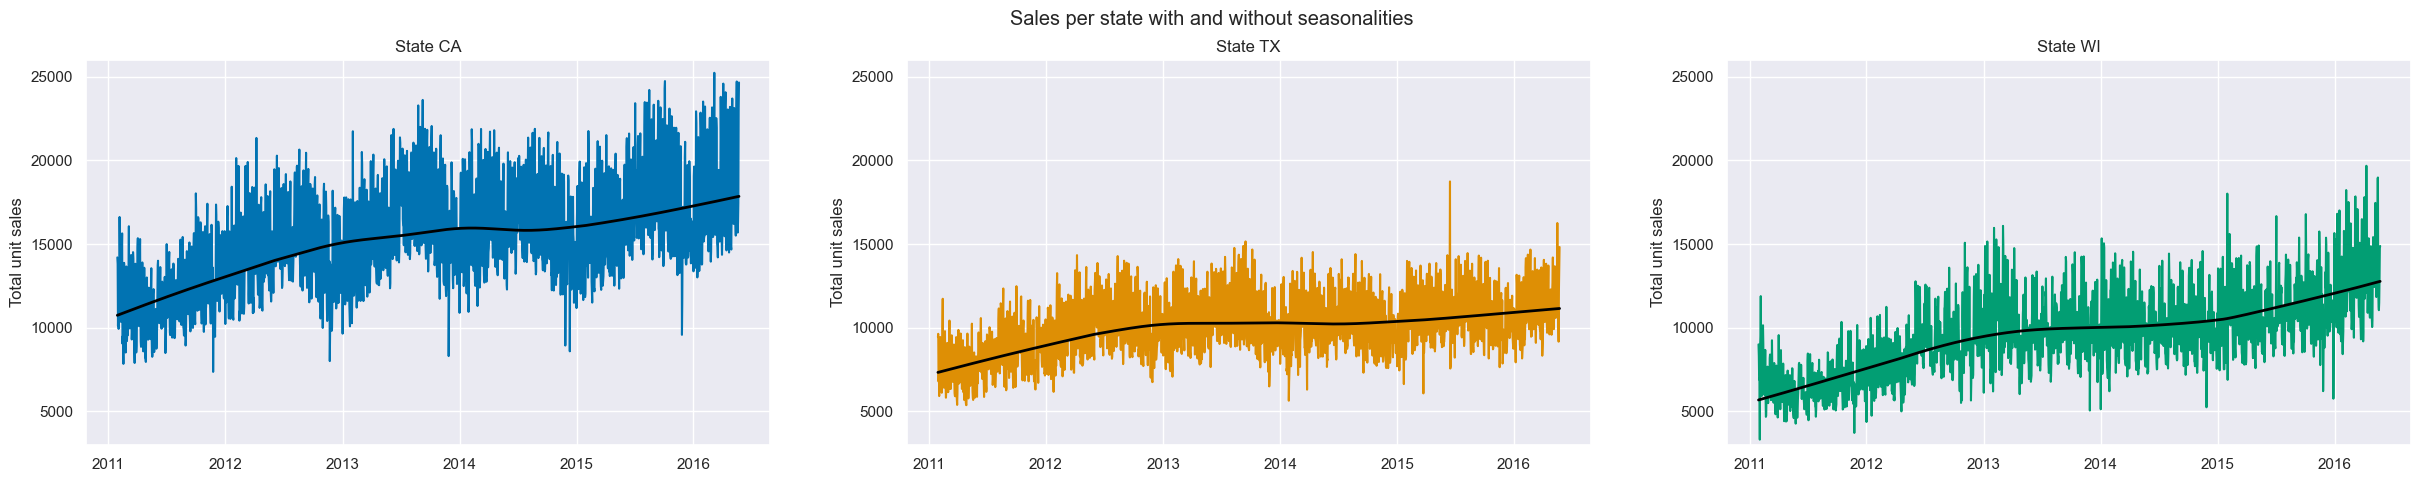

In [150]:
sns.set_palette("colorblind")
fig, ax = plt.subplots(1,3,figsize=(30,5))
state_ids = grouped_sales_train_with_loess['state_id'].unique()
fig.suptitle("Sales per state with and without seasonalities")


for state in range(len(state_ids)):
    ax[state].set_title(f"State {state_ids[state]}")
    ax[state].set_ylabel("Total unit sales")
    grouped_data = grouped_sales_train_with_loess[grouped_sales_train_with_loess['state_id'] == state_ids[state]].groupby(['dates']).sum(['sale', 'loess']).drop(['mean_sales', 'sales_rel'], axis=1)
    ax[state].plot(grouped_data.index, grouped_data['sales'], label='Time Series', color=sns.color_palette("colorblind")[state], linewidth=1.5)
    ax[state].plot(grouped_data.index, grouped_data['loess'], label='LOESS', color='black', linewidth=2)
    ax[state].set_ylim(3000, 26000)   

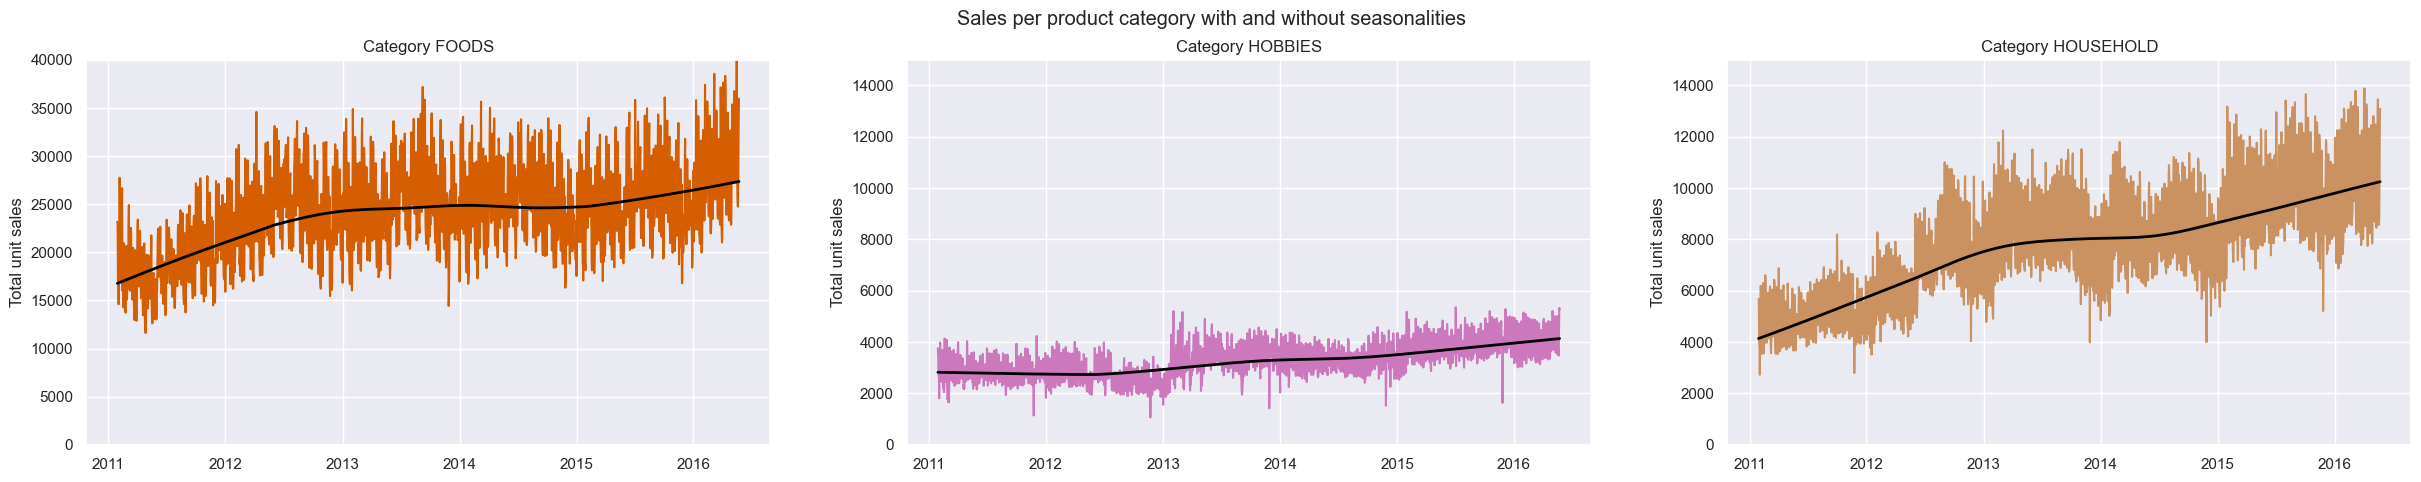

In [ ]:
sns.set_palette("colorblind")
fig, ax = plt.subplots(1,3,figsize=(30,5))
category_ids = grouped_sales_train_with_loess['cat_id'].unique()
fig.suptitle("Sales per product category with and without seasonalities")

for category in range(len(category_ids)):
    ax[category].set_title(f"Category {state_ids[category]}")
    ax[category].set_ylabel("Total unit sales")
    grouped_per_cat = grouped_sales_train_with_loess[grouped_sales_train_with_loess['cat_id'] == state_ids[category]].groupby(['dates']).sum(['sales', 'loess']).drop(['mean_sales', 'sales_rel'], axis=1)
    ax[category].plot(grouped_per_cat.index, grouped_per_cat['sales'], label='Time Series', color=sns.color_palette("colorblind")[category+3], linewidth=1.5)
    ax[category].plot(grouped_per_cat.index, grouped_per_cat['loess'], label='LOESS', color='black', linewidth=2)
    if category == 0:
        ax[category].set_ylim(0, 40000)   
    else:
        ax[category].set_ylim(0, 15000)

##### Weekly seasonality by state and by product category 

<Axes: title={'center': 'Weekly Seasonality per category'}, xlabel='wday', ylabel='Relative Sales'>

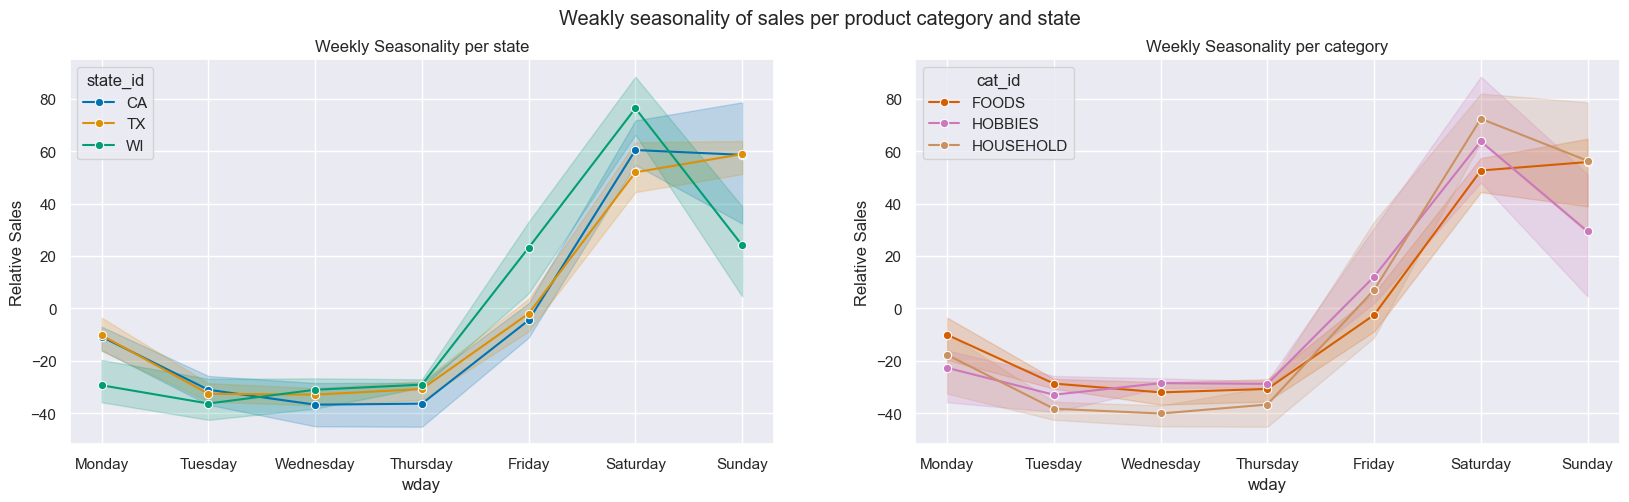

In [165]:
weekly_sales =grouped_sales_train_with_loess.groupby(['cat_id','state_id','wday'], as_index=False)['sales_rel'].sum().set_index(['cat_id', 'state_id'])
fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle("Weakly seasonality of sales per product category and state")

ax[0].set_title("Weekly Seasonality per state")
ax[0].set_ylabel("Relative Sales")
sns.lineplot(data=weekly_sales, x='wday', y='sales_rel', hue='state_id', marker='o', linewidth=1.5, ax=ax[0])

ax[1].set_title("Weekly Seasonality per category")
ax[1].set_ylabel("Relative Sales")
sns.lineplot(data=weekly_sales, x='wday', y='sales_rel', hue='cat_id', palette=sns.color_palette("colorblind")[3:6], marker='o', linewidth=1.5, ax=ax[1])



The weekly pattern is strong, with Sat and Sun standing out prominently. Also Monday seems to benefit a bit from the weekend effect. After scaling, the weekday vs weekend pattern is very similar for all 3 states, except for an interesting downturn in Sunday sales in WI.

##### Monthly seasonality by state and by product category 

<Axes: title={'center': 'Monthly Seasonality per category'}, xlabel='month', ylabel='Relative Sales'>

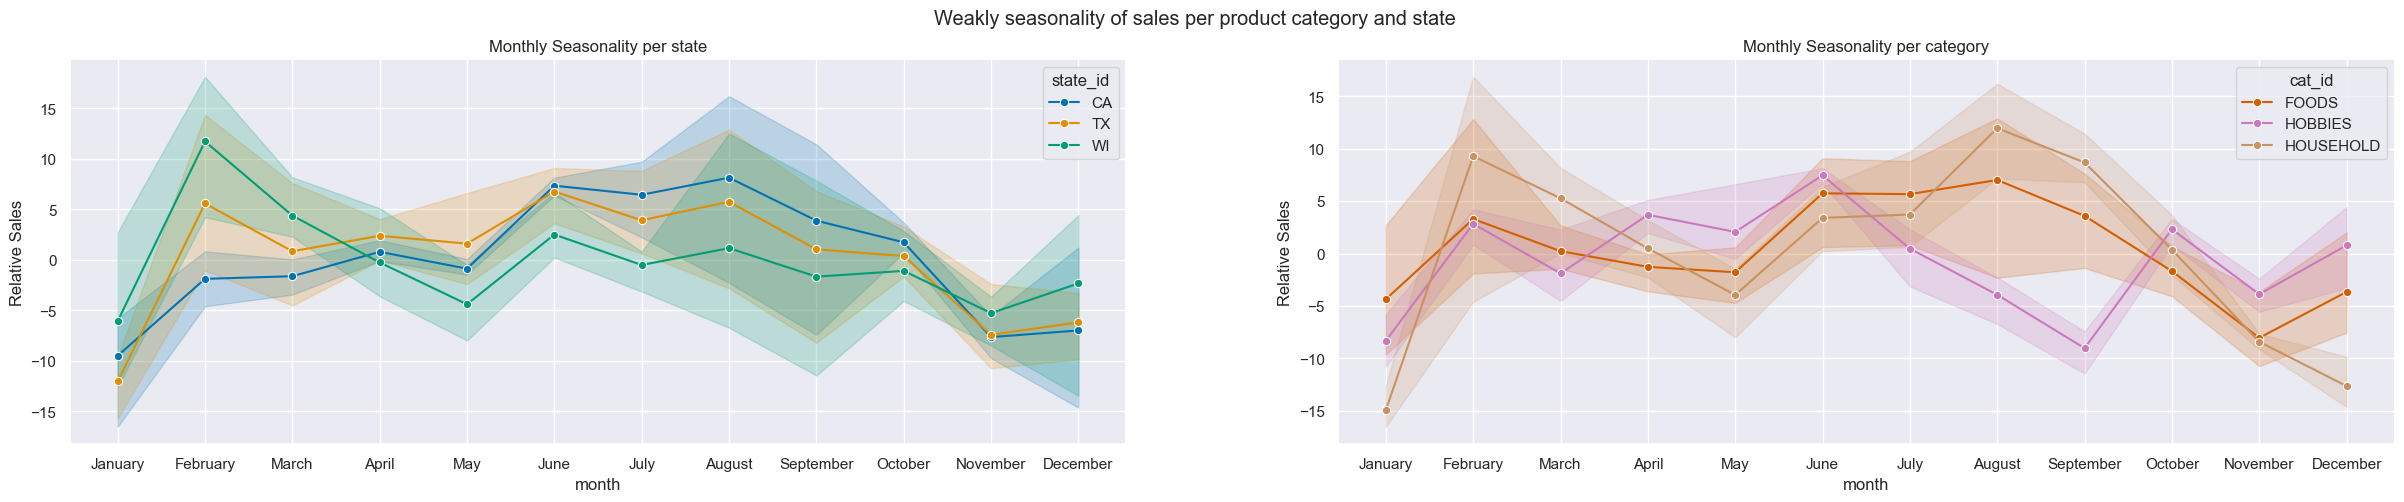

In [ ]:
monthly_sales =foo_lowess.groupby(['cat_id','state_id','month'], as_index=False)['sales_rel'].sum().set_index(['cat_id', 'state_id'])
fig, ax = plt.subplots(1,2,figsize=(30,5))
fig.suptitle("Monthly seasonality of sales per product category and state")

ax[0].set_title("Monthly Seasonality per state")
ax[0].set_ylabel("Relative Sales")
sns.lineplot(data=monthly_sales, x='month', y='sales_rel', hue='state_id', marker='o', linewidth=1.5, ax=ax[0])

ax[1].set_title("Monthly Seasonality per category")
ax[1].set_ylabel("Relative Sales")
sns.lineplot(data=monthly_sales, x='month', y='sales_rel', hue='cat_id', palette=sns.color_palette("colorblind")[3:6], marker='o', linewidth=1.5, ax=ax[1])

The monthly seasonalities are a bit more complex. There is a dip in the winter months of Nov and Dec and a second, generally shallower dip in the summer months May, Jun, and Jul . WI is again the odd state out: it sells notably less in the summer compared to TX and especially CA; so much so that the Feb/Aug ratio is inverted for WI vs CA/TX.

##### Weekly and monthly seasonality by product category and state

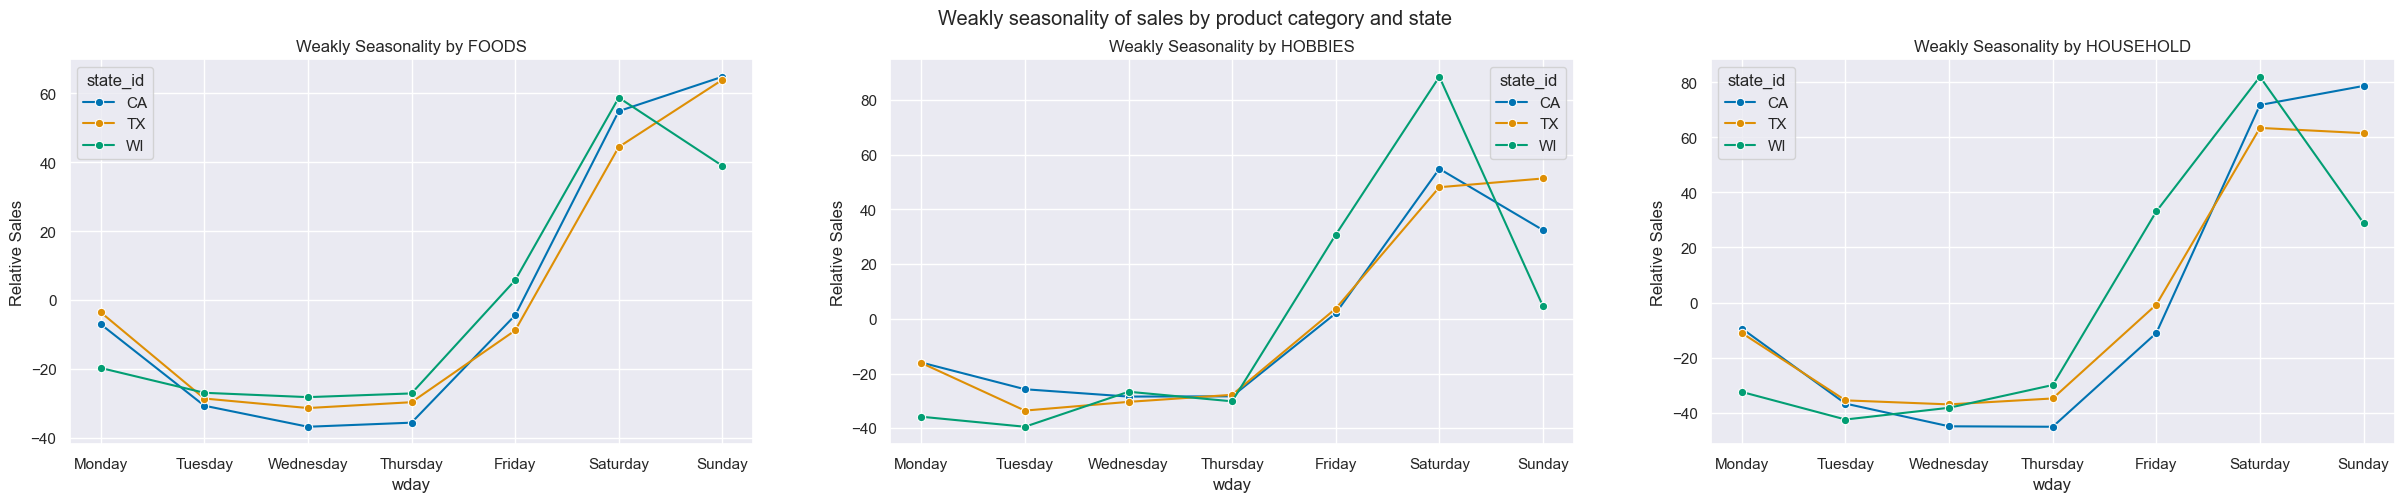

In [183]:
fig, ax = plt.subplots(1,3,figsize=(30,5))
fig.suptitle("Weakly seasonality of sales by product category and state")

for cat_id in range(len(category_ids)):
    ax[cat_id].set_title(f"Weakly Seasonality by {category_ids[cat_id]}")
    ax[cat_id].set_ylabel("Relative Sales")
    sns.lineplot(data=weekly_sales.loc[category_ids[cat_id]], x='wday', y='sales_rel', hue='state_id', marker='o', linewidth=1.5, ax=ax[cat_id])

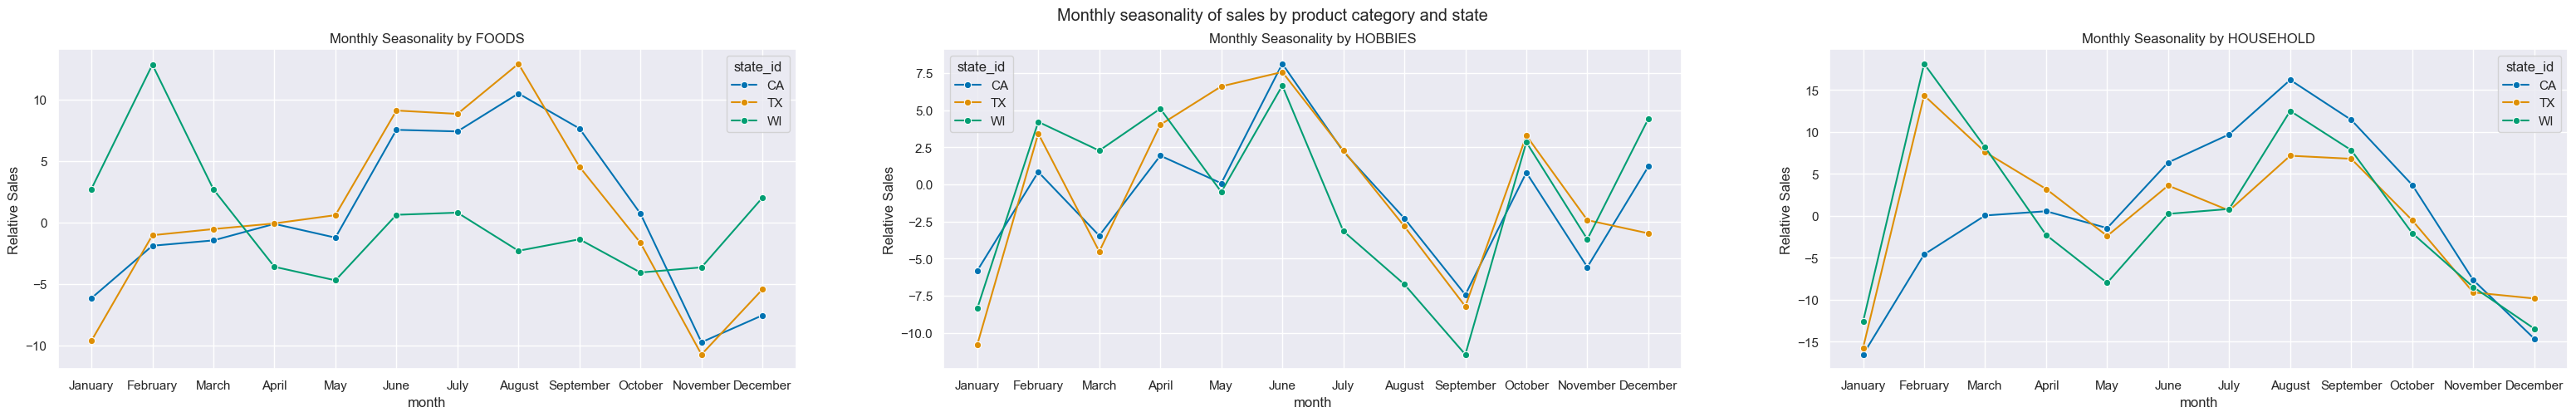

In [186]:
fig, ax = plt.subplots(1,3,figsize=(39,5))
fig.suptitle("Monthly seasonality of sales by product category and state")

for cat_id in range(len(category_ids)):
    ax[cat_id].set_title(f"Monthly Seasonality by {category_ids[cat_id]}")
    ax[cat_id].set_ylabel("Relative Sales")
    sns.lineplot(data=monthly_sales.loc[category_ids[cat_id]], x='month', y='sales_rel', hue='state_id', marker='o', linewidth=1.5, ax=ax[cat_id])

The weekly patterns for the “foods” category are very close for all 3 states, and WI shows some deviations for “hobbies” and “household”. We also see the Wisconsin’s characteristic Sunday dip for all 3 categories.

The monthly patterns show some interesting signatures: For “foods”, CA and TX are pretty close but WI shows that inverted summer/winter ratio. In contrast, the 3 states are much more similar to each other in the “hobbies” category. And when it comes to “household” items, CA doesn’t seem to sell as much of them during the first 3 months of the year but slightly more in the summer; compared to WI and TX.

# Tasks
Now it is time to look at the additional explanatory variables, but this time it is your turn. Analyze the data set and answer the following questions:
1. How many days per month do SNAP activities take place for each of the states?
2. How do SNAP activities affect daily sales in each state? For which product category do we see the greatest impact of SNAP days on unit sales?
3. How many days are special days? What is the percentage of each type of event?
4.  What effect do the special days have on daily unit sales in general? In which state and for which product type do they have the largest effect?

### 1. How many days each month SNAP activties take place for each of the states?

### 2. How do SNAP activities affect daily unit sales in each state? For which product category do we see the greatest impact of SNAP days on unit sales?

### 3. How many days are special days? What is the share of each event type?

### 4. What effect do the special days have on daily unit sales in general? In which state and for which product type do they have the largest effect?